In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import math
import os.path
from os import path
from scipy.signal import butter, filtfilt, lfilter
from scipy import fftpack
import warnings
import seaborn as sns
# from dtw import *
from sklearn.datasets import make_classification

# from dtaidistance import dtw
# from dtaidistance import dtw_visualisation as dtwvis
from sklearn.preprocessing import MinMaxScaler
# scipy interpolate
from scipy.interpolate import interp1d

from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis
from sklearn.preprocessing import MinMaxScaler
# scipy interpolate
from scipy.interpolate import interp1d

from scipy.signal import argrelextrema

import stumpy
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.dates as dates
from matplotlib.patches import Rectangle

import itertools

from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis

import quaternion



foots = ['rightfoot', 'leftfoot', 'bothfoot']
directions = ['RecordingForth', 'RecordingBack']
trackers = ['FootL', 'FootR']
all_gestures = [
    'NormalWalking', 'Delay', 'TapWithHeel', 'TapWithFootRotatedInwards',
    'BendingBehind', 'Rush', 'LiftInFront', 'KickForward', 'TapOuward',
    'TapInFrontOfTheOtherFoot', 'DraggingInFront', 'TapInward', 'ToeTapBehind',
    'MidairRotationInwards', 'KickOutward', 'KickInward',
    'MidairRotationOutwards', 'DraggingBehind', 'TapWithFootRotatedOutwards',
    'SmallStep', 'Click', 'BigStep', 'ToeTapInFront'
]

all_attributes_dict = {
    'position': ['pos_z', 'pos_y', 'pos_x'],
    'velocity': ['pos_z_v', 'pos_y_v', 'pos_x_v'],
    'acceleration': ['pos_z_a', 'pos_y_a', 'pos_x_a'],
    'angle': ['ang_z', 'ang_y', 'ang_x'],
    'angle_velocity': ['ang_z_v', 'ang_y_v', 'ang_x_v'],
    'angle_acceleration': ['ang_z_a', 'ang_y_a', 'ang_x_a'],
}

all_attributes = [
    'pos_z', 'pos_y', 'pos_x', 'pos_z_v', 'pos_y_v', 'pos_x_v', 'pos_z_a',
    'pos_y_a', 'pos_x_a', 'ang_z', 'ang_y', 'ang_x', 'ang_z_v', 'ang_y_v',
    'ang_x_v', 'ang_z_a', 'ang_y_a', 'ang_x_a'
]
# User01, 02 to User26
# all_users = ['User' + str(i) for i in range(1, 27)]
all_users = ['User' + f'0{i}' if i < 10 else 'User' + str(i) for i in range(1, 27)]
raw_data_dir_path = ''
parsed_data_dir_path = ''
figs_dir_path = ''

In [ ]:
def fetch_data(user_id):
    parsed_data_dir_path = os.path.join('./parsed_data/', user_id)
    all_data = pd.read_csv(os.path.join(parsed_data_dir_path, 'all_data.csv'))
    all_gesture_name = all_data['Gesture'].unique()

    all_data['ang_x'] = all_data['ang_x'].apply(lambda x: np.sin(x * np.pi / 180))
    all_data['ang_y'] = all_data['ang_y'].apply(lambda x: np.sin(x * np.pi / 180))
    all_data['ang_z'] = all_data['ang_z'].apply(lambda x: np.sin(x * np.pi / 180))

    return all_data, all_gesture_name


In [ ]:
def get_gesture_data(data, gesture_name, foot, direction):
    local_gesture_data = data[(data['Gesture'] == gesture_name)
                              & (data['Foot'] == foot) &
                              (data['Direction'] == direction)]


    checkpoint_list = local_gesture_data[local_gesture_data['Type'] ==
                                   'E']['Checkpoint'].tolist()
    checked_checkpoint_list = []
    for checkpoint in checkpoint_list:
        if checkpoint not in checked_checkpoint_list:
            if checkpoint_list.count(checkpoint) > 1:

                if type(checkpoint) == float:
                    candidates = local_gesture_data[
                        (local_gesture_data['Checkpoint'].isnull())
                        & (local_gesture_data['Type'] == 'E') &
                        (local_gesture_data['TrackerName'].isnull())]
                else:
                    candidates = local_gesture_data[
                        (local_gesture_data['Checkpoint'] == checkpoint)
                        & (local_gesture_data['Type'] == 'E') &
                        (local_gesture_data['TrackerName'].isnull())]

                # print(candidates['Time'])
                if candidates.size > 0:
                    start_time = candidates['Time'].iloc[0]
                    end_time = candidates['Time'].iloc[-1]
                    # print('checkpoint: ', checkpoint, 'start_time: ', start_time, 'end_time: ', end_time)

                    if type(checkpoint) == float:
                        local_gesture_data = local_gesture_data.drop(local_gesture_data[
                                                                         (local_gesture_data['Checkpoint'].isnull())
                                                                         & (local_gesture_data['Time'] >= start_time) &
                                                                         (local_gesture_data['Time'] < end_time)].index)
                    else:
                        local_gesture_data = local_gesture_data.drop(local_gesture_data[
                                                                         (local_gesture_data['Checkpoint'] == checkpoint)
                                                                         & (local_gesture_data['Time'] >= start_time) &
                                                                         (local_gesture_data['Time'] < end_time)].index)
                    checked_checkpoint_list.append(checkpoint)

    return local_gesture_data

In [ ]:
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    # print('b: ', b, 'a: ', a)
    y = lfilter(b, a, data)
    return y

def find_valleys(data, threshold):
    valleys = []
    data = np.array(data)

    for i in range(1, len(data) - 1):
        if data[i] < data[i - 1] and data[i] < data[i + 1] and data[i] <= threshold:
            valleys.append(i)

    return valleys

def cut_step_data(tracker_data, gestureName, tracker_name, foot, direction):

    tracker_data = tracker_data.copy()

    # find local minima of the data
    minima = (np.diff(np.sign(np.diff(tracker_data['pos_z_a'][2:]))) > 0).nonzero()[0] + 1

    minima_data = {}
    for index in minima:
        minima_data[index] = tracker_data['pos_z_a'].iloc[index]

    # sort the minima data by value
    minima_data = {k: v for k, v in sorted(minima_data.items(), key=lambda item: item[1])}

    maxima3 = (np.diff(np.sign(np.diff(tracker_data['pos_z_a_3'][4:]))) < 0).nonzero()[0] + 1

    overlapped_minima = []
    for index in maxima3:
        # index-2 to index+2 in minima
        overlapped_minima.extend([i for i in minima if i >= index + 3 and i <= index + 5])

    # segment the minima_data by values with largest gap and second largest gap
    minima_data_list = list(minima_data.items())
    largest_gap = 0
    largest_gap_index = 0

    for i in range(len(minima_data_list) - 1):
        gap = minima_data_list[i + 1][1] - minima_data_list[i][1]
        if gap > largest_gap:
            largest_gap = gap
            largest_gap_index = i


    second_largest_gap = 0
    second_largest_gap_index = 0

    largest_groups = minima_data_list[largest_gap_index + 1:]

    for i in range(len(largest_groups) - 1):
        gap = largest_groups[i + 1][1] - largest_groups[i][1]
        if gap > second_largest_gap:
            second_largest_gap = gap
            second_largest_gap_index = i

    groups = []
    groups.append(list(minima_data.keys())[largest_gap_index + 1 + second_largest_gap_index + 1:])
    groups.append(list(minima_data.keys())[largest_gap_index + 1:second_largest_gap_index + largest_gap_index + 1])
    groups.append(list(minima_data.keys())[:largest_gap_index + 1])

    groups.append(overlapped_minima)
    groups.append(maxima3)
    groups.append(minima)

    valleys = []
    threshold = (np.mean(tracker_data['pos_z_a'][2:].iloc[groups[2]]) - np.mean(tracker_data['pos_z_a'][2:].iloc[groups[0]])) / 2
    valleys1 = find_valleys(tracker_data['pos_z_a'][2:], threshold)
    valleys2 = np.sort(groups[2])

    for data_index in groups[1]:
        # if distance between data & thresh is lower than distance between data & np.mean(groups[0])
        data = tracker_data['pos_z_a'][2:].iloc[data_index]
        if abs(data - threshold) < abs(data - np.mean(tracker_data['pos_z_a'][2:].iloc[groups[0]])):
            valleys2 = np.append(valleys2, data_index)


    # compare valleys1 and valleys, concatenate them and sort them and remove the duplicates
    valleys = np.sort(np.concatenate((valleys2, valleys1, overlapped_minima)))
    valleys = np.unique(valleys)

    # cut the step data from the valleys
    all_steps = []
    for i in range(len(valleys) - 1):
        step = [valleys[i], valleys[i + 1]]
        all_steps.append(step)

    all_steps_data = []
    for step in all_steps:
        step_data = tracker_data[int(step[0]):int(step[1])]
        all_steps_data.append(step_data)


    return all_steps_data, threshold, groups

In [ ]:
def get_tracker_data(all_data, gesture, foot, direction, tracker_name, butter_a_param):
    gesture_data = get_gesture_data(all_data, gesture, foot, direction)
    head_data = gesture_data[gesture_data['TrackerName'] == 'Head']
    tracker_data = gesture_data[gesture_data['TrackerName'] == tracker_name]
    if direction == 'RecordingBack':
        warnings.simplefilter("ignore")
        tracker_data['pos_z'] = -tracker_data['pos_z']

        if tracker_name == 'FootL':
            tracker_data['ang_z'] = -tracker_data['ang_z']
            tracker_data['ang_y'] = -tracker_data['ang_y']
            tracker_data['pos_x_cal'] = tracker_data[
                'pos_x'].subtract(head_data['pos_x'], fill_value=0)

        elif tracker_name == 'FootR':
            tracker_data['pos_x_cal'] = head_data[
                'pos_x'].subtract(tracker_data['pos_x'],
                                    fill_value=0)

    elif direction == 'RecordingForth':
        warnings.simplefilter("ignore")
        if tracker_name == 'FootL':
            tracker_data['ang_y'] = -tracker_data['ang_y']
            tracker_data['ang_z'] = -tracker_data['ang_z']
            tracker_data['pos_x'] = -tracker_data['pos_x']
            tracker_data['pos_x_cal'] = head_data[
                'pos_x'].subtract(tracker_data['pos_x'],
                                    fill_value=0)

        elif tracker_name == 'FootR':
            tracker_data['pos_x_cal'] = tracker_data[
                'pos_x'].subtract(head_data['pos_x'], fill_value=0)



    for attr in [
        'pos_x', 'pos_y', 'pos_z', 'ang_x', 'ang_y', 'ang_z'
    ]:
        warnings.simplefilter("ignore")
        tracker_data[attr + '_v'] = tracker_data[attr].diff()
        tracker_data[attr + '_a'] = tracker_data[attr +
                                                '_v'].diff()

        tracker_data[attr + '_a'][2:] = butter_lowpass_filter(
            tracker_data[attr + '_a'][2:], butter_a_param, 100, 5)  # butter_a_param vary for different purposes

        tracker_data[attr + '_a_2'] = tracker_data[attr +
                                                '_a'].diff()
        tracker_data[attr + '_a_3'] = tracker_data[attr +
                                                '_a_2'].diff()

        tracker_data[attr + '_v'][1:] = butter_lowpass_filter(
            tracker_data[attr + '_v'][1:], 12, 100, 5)


    return tracker_data, gesture_data


user:  User02
user:  User03
user:  User04
user:  User05
user:  User06
user:  User07
user:  User08
user:  User09
user:  User10
user:  User11
user:  User12
user:  User13
user:  User14
user:  User15
user:  User16
user:  User17
user:  User18
user:  User19
user:  User20
user:  User21
user:  User22
user:  User23
user:  User24
user:  User25
user:  User26
all normal steps count:  844


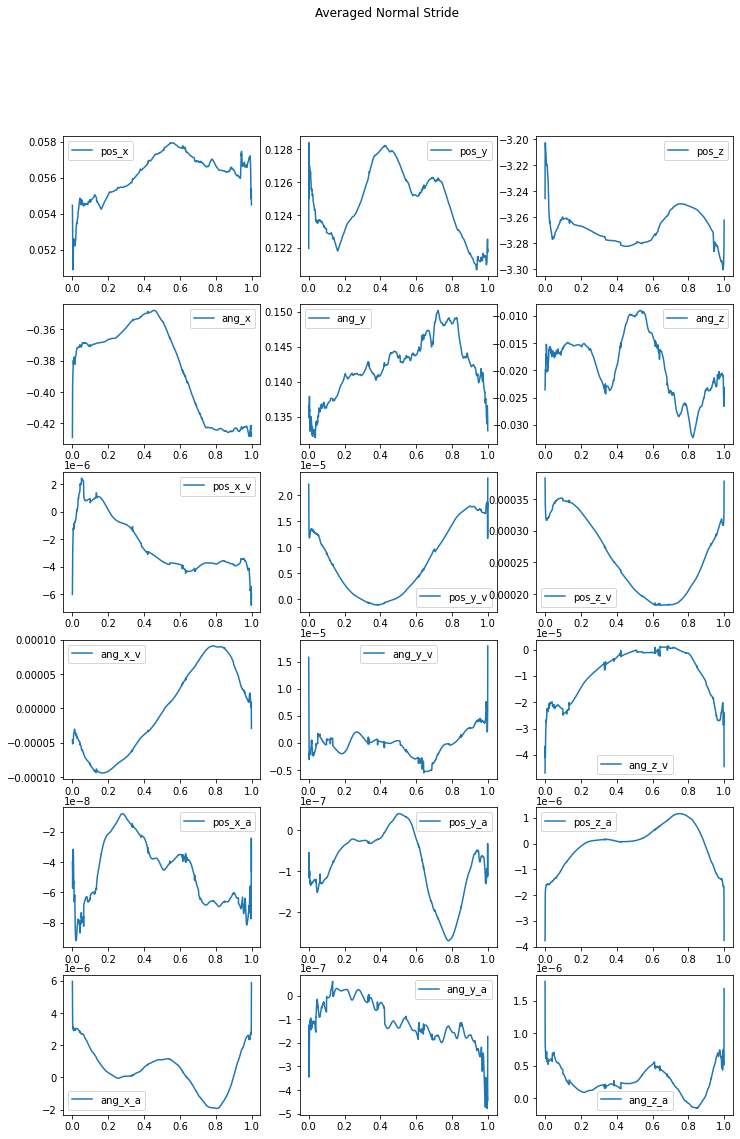

In [ ]:
def get_normal_step_data(all_data):
    gesture_data_normal = pd.DataFrame()
    for direction in directions[:]:
        gesture_data = get_gesture_data(all_data, 'NormalWalking', 'bothfoot', direction)
        # gesture_data_normal = pd.concat([gesture_data_normal, gesture_data], ignore_index=True)
        head_data = gesture_data[gesture_data['TrackerName'] == 'Head']

        for tracker in trackers[:]:
            tracker_data_normal = gesture_data[gesture_data['TrackerName'] == tracker]
            if direction == 'RecordingBack':
                warnings.simplefilter("ignore")
                tracker_data_normal['pos_z'] = -tracker_data_normal['pos_z']

                if tracker == 'FootL':
                    tracker_data_normal['ang_z'] = -tracker_data_normal['ang_z']
                    tracker_data_normal['ang_y'] = -tracker_data_normal['ang_y']
                    tracker_data_normal['pos_x_cal'] = tracker_data_normal['pos_x'].subtract(head_data['pos_x'], fill_value=0)

                elif tracker == 'FootR':
                    tracker_data_normal['pos_x_cal'] = head_data['pos_x'].subtract(tracker_data_normal['pos_x'], fill_value=0)

            elif direction == 'RecordingForth':
                warnings.simplefilter("ignore")
                if tracker == 'FootL':
                    tracker_data_normal['ang_y'] = -tracker_data_normal['ang_y']
                    tracker_data_normal['ang_z'] = -tracker_data_normal['ang_z']
                    tracker_data_normal['pos_x'] = -tracker_data_normal['pos_x']
                    tracker_data_normal['pos_x_cal'] = head_data['pos_x'].subtract(tracker_data_normal['pos_x'], fill_value=0)


                elif tracker == 'FootR':
                    tracker_data_normal['pos_x_cal'] = tracker_data_normal['pos_x'].subtract(head_data['pos_x'], fill_value=0)



            for attr in ['pos_x', 'pos_y', 'pos_z', 'ang_x', 'ang_y', 'ang_z']:
                warnings.simplefilter("ignore")
                tracker_data_normal[attr + '_v'] = tracker_data_normal[attr].diff() / tracker_data_normal['Time'].diff()
                tracker_data_normal[attr + '_a'] = tracker_data_normal[attr + '_v'].diff() / tracker_data_normal['Time'].diff()

                tracker_data_normal[attr + '_v'][1:] = butter_lowpass_filter(tracker_data_normal[attr + '_v'][1:], 1, 100, 5)
                tracker_data_normal[attr + '_a'][2:] = butter_lowpass_filter(tracker_data_normal[attr + '_a'][2:], 2, 100, 5)

                tracker_data_normal[attr + '_a_2'] = tracker_data_normal[attr + '_a'].diff()
                tracker_data_normal[attr + '_a_3'] = tracker_data_normal[attr +'_a_2'].diff()

            gesture_data_normal = pd.concat([gesture_data_normal, tracker_data_normal], ignore_index=True)


    all_normal_steps, thresh, groups = cut_step_data(gesture_data_normal, 'NormalWalking', 'bothfoot', 'bothfoot', 'bothfoot')

    print('all normal steps count: ', len(all_normal_steps))

    return all_normal_steps



def get_normalized_normal_stide(all_normal_strides):
    # get one single representative normal stride normalize from all normal strides, in attribute: pos_z

    # scale all steps' time by min-max scaler
    for step in all_normal_strides:
        scaler = MinMaxScaler()
        step['Time'] = scaler.fit_transform(step['Time'].values.reshape(-1, 1))
        step['Time'] = step['Time'] * (step['Time'].iloc[-1] - step['Time'].iloc[0]) + step['Time'].iloc[0]


    # all_normal_strides = [all_normal_strides[i] for i in range(len(all_normal_strides)) if i not in [4, 10, 15]]
    # plot_all_steps(all_normal_strides)
    max_steps_length = max([step.shape[0] for step in all_normal_strides])


    new_all_normal_strides = []
    for step in all_normal_strides:
        step.fillna(0, inplace=True)
        # interpolate the step to the same data length
        df = pd.DataFrame()
        df['Time'] = np.linspace(step['Time'].iloc[0], step['Time'].iloc[-1], max_steps_length)
        for attr in ['pos_x', 'pos_y', 'pos_z', 'ang_x', 'ang_y', 'ang_z']:
            df[attr] = np.interp(df['Time'], step['Time'], step[attr])
            df[attr + '_v'] = np.interp(df['Time'], step['Time'], step[attr + '_v'])
            df[attr + '_a'] = np.interp(df['Time'], step['Time'], step[attr + '_a'])

        new_all_normal_strides.append(df)


    # get the average of all steps
    average_stride = pd.DataFrame()
    average_stride['Time'] = np.mean([step['Time'] for step in new_all_normal_strides], axis=0)
    for attr in ['pos_x', 'pos_y', 'pos_z', 'ang_x', 'ang_y', 'ang_z']:
        average_stride[attr] = np.mean([step[attr] for step in new_all_normal_strides], axis=0)
        average_stride[attr + '_v'] = np.mean([step[attr + '_v'] for step in new_all_normal_strides], axis=0)
        average_stride[attr + '_a'] = np.mean([step[attr + '_a'] for step in new_all_normal_strides], axis=0)


    return average_stride


def plot_averaged_normal_stride(avergae_stride):
    fig, ax = plt.subplots(6, 3, figsize=(12, 18))
    fig.suptitle('Averaged Normal Stride')

    for index, attr in enumerate(['pos_x', 'pos_y', 'pos_z', 'ang_x', 'ang_y', 'ang_z']):
        ax[index // 3, index % 3].plot(avergae_stride['Time'], avergae_stride[attr], label=attr)
        ax[index // 3, index % 3].legend()

    for index, attr in enumerate(['pos_x', 'pos_y', 'pos_z', 'ang_x', 'ang_y', 'ang_z']):
        ax[index // 3 + 2, index % 3].plot(avergae_stride['Time'], avergae_stride[attr + '_v'], label=attr + '_v')
        ax[index // 3 + 2, index % 3].legend()

    for index, attr in enumerate(['pos_x', 'pos_y', 'pos_z', 'ang_x', 'ang_y', 'ang_z']):
        ax[index // 3 + 4, index % 3].plot(avergae_stride['Time'], avergae_stride[attr + '_a'], label=attr + '_a')
        ax[index // 3 + 4, index % 3].legend()

    plt.show()


test_data = pd.DataFrame()
for user in all_users[1:26]:
    print('user: ', user)
    all_data, all_gesture_name = fetch_data(user)
    test_data = pd.concat([test_data, all_data], ignore_index=True)

all_normals = get_normal_step_data(test_data)
normal_stride = get_normalized_normal_stide(all_normals)
plot_averaged_normal_stride(normal_stride)

In [ ]:
def get_query_pattern(tracker_data, attr_name):
    minimums = argrelextrema(tracker_data[attr_name].values, np.less)
    local_minima = tracker_data[attr_name].values[minimums]
    local_minima_index = minimums[0]
    thresh = np.mean(local_minima) - np.std(local_minima)
    lowest_minimums = [(index, value) for index, value in enumerate(local_minima) if value < thresh]
    # lowest_local_minima_index = [local_minima_index[i] for i, _ in lowest_minimums]

    if len(lowest_minimums) < 2:
        query_pattern = normal_stride[attr_name].values
    else:
        query_pattern = (tracker_data[attr_name].values)[local_minima_index[lowest_minimums[0][0]]: local_minima_index[lowest_minimums[1][0]]]

    # last lowest minimum index in tracker_data
    last_lowest_index = local_minima_index[lowest_minimums[-1][0]]
    return query_pattern, last_lowest_index



def get_all_strides(matches, query_pattern, tracker_data, last_lowest_index):
    matches_sorted = sorted(matches, key=lambda x: tracker_data['Time'].iloc[x[1]])
    gesture_strides = []
    normal_strides = []
    start, end = 0, 0
    for index, match in enumerate(matches_sorted):
        start = tracker_data['Time'].iloc[match[1]]

        if (match[1] + query_pattern.size) >= len(tracker_data['Time']) - 1:
            end = tracker_data['Time'].iloc[-1]
        else:
            end = tracker_data['Time'].iloc[match[1] + query_pattern.size]

        normal_strides.append((start, end, end-start))

    # average_duration = np.mean([stride[2] for stride in normal_strides]) + np.std([stride[2] for stride in normal_strides])
    for index, stride in enumerate(normal_strides[:-1]):
        if normal_strides[index+1][0] - stride[1] > 100:
            gesture_strides.append((stride[1], normal_strides[index+1][0], normal_strides[index+1][0]-stride[1]))


    all_strides = []
    for index, stride in enumerate(gesture_strides):
        if stride[1]-stride[0] < 850:
            continue
        all_strides.append((stride[0], stride[1], stride[1]-stride[0]))

    for index, stride in enumerate(normal_strides):
        all_strides.append((stride[0], stride[1], stride[1]-stride[0]))


    all_strides = sorted(all_strides, key=lambda x: x[0])

    for index, stride in enumerate(all_strides[:-1]):
        # if next start - current end > 0, then change next start to current end
        if all_strides[index+1][0] - stride[1] > 0:
            if all_strides[index+1][0] - stride[1] < 850:
                all_strides[index] = (stride[0], all_strides[index+1][0], all_strides[index+1][0]-stride[0])
            else:
                all_strides[index+1] = (stride[1], all_strides[index+1][1], all_strides[index+1][1]-stride[1])

        elif all_strides[index+1][0] - stride[1] < 0:
            all_strides[index] = (stride[0], all_strides[index+1][0], all_strides[index+1][0]-stride[0])

    for index, stride in enumerate(all_strides[:-1]):
        if all_strides[index+1][0] - stride[1] > 0:
            all_strides[index+1] = (stride[1], all_strides[index+1][1], all_strides[index+1][1]-stride[1])
        elif all_strides[index+1][0] - stride[1] < 0:
            all_strides[index] = (stride[0], all_strides[index+1][0], all_strides[index+1][0]-stride[0])

        # if last stride end before the last minimums (checkpoints[-1]) and no more step behind, then add a stride from last stride end to last minimums
        if index == len(all_strides) - 2:
            last_minimum = tracker_data['Time'].iloc[last_lowest_index]
            if all_strides[index+1][1] < last_minimum and all_strides[index+1][1] + 850 < last_minimum:
                # all_strides.append((all_strides[index+1][1], tracker_data['Time'].iloc[-1], tracker_data['Time'].iloc[-1]-all_strides[index+1][1]))
                all_strides.append((all_strides[index+1][1], last_minimum, last_minimum-all_strides[index+1][1]))


    all_strides_df = pd.DataFrame(all_strides, columns=['start', 'end', 'duration'])

    return all_strides_df




def get_gesture_normals(matches, query_pattern, tracker_data, all_strides_df):
    matches_sorted = sorted(matches, key=lambda x: tracker_data['Time'].iloc[x[1]])
    gesture_strides = []
    normal_strides = []
    for index, match in enumerate(matches_sorted):
        start = tracker_data['Time'].iloc[match[1]]
        if match[1] + query_pattern.size >= len(tracker_data['Time']):
            end = tracker_data['Time'].iloc[-1]
        else:
            end = tracker_data['Time'].iloc[match[1] + query_pattern.size]
        normal_strides.append((start, end))


    for index, stride in enumerate(normal_strides):
        if index == len(normal_strides) - 1: break
        if normal_strides[index+1][0] - stride[1] > 100:
            gesture_strides.append((stride[1], normal_strides[index+1][0]))

    return gesture_strides

In [ ]:
def plot_strides(tracker_data, gesture, foot, direction, tracker_name, all_strides_df, gesture_strides, gesture_data):
    fig, ax = plt.subplots(figsize=(20, 6))
    fig.suptitle('Gesture: ' + gesture + '/ Foot: ' + foot + '/ Direction: ' + direction + '/ Tracker: ' + tracker_name, fontsize=14)

    sns.lineplot(x=tracker_data['Time'], y=tracker_data['pos_z_a']
                * 1000, linewidth=1, color='grey', label='pos_z_a')
    sns.lineplot(x=tracker_data['Time'], y=tracker_data['ang_y']
                * 10, linewidth=1, color='purple', label='ang_y')
    sns.lineplot(x=tracker_data['Time'], y=tracker_data['pos_y']
                * 10, linewidth=1, color='red', label='pos_y')

    for index in range(len(all_strides_df)):
        # if gesture_time falls into the stride, then label it as gesture with axvspan
        if (len(gesture_strides) > 0):
            for start, end in gesture_strides:
                # thresh the middle point (unixtimestamp) of start, end
                thresh = np.mean([start, end])
                ax.axvline(x=thresh, color='r', linestyle='-', linewidth=1)

                if all_strides_df['start'][index] < thresh and all_strides_df['end'][index] > thresh:
                    ax.axvspan(
                        all_strides_df['start'][index], all_strides_df['end'][index], alpha=0.5, color='lightcoral')
                else:
                    ax.axvline(x=all_strides_df['start'][index],
                                color='green', linestyle='-', linewidth=1)
                    ax.text(all_strides_df['start'][index], 6,
                            all_strides_df['duration'][index], rotation=90)
                    ax.axvline(x=all_strides_df['end'][index],
                                color='green', linestyle='-', linewidth=1)
        else:
            ax.axvline(x=all_strides_df['start'][index],
                        color='green', linestyle='-', linewidth=1)
            ax.text(all_strides_df['start'][index], 6,
                    all_strides_df['duration'][index], rotation=90)
            ax.axvline(x=all_strides_df['end'][index],
                        color='green', linestyle='-', linewidth=1)

    checkpoints = gesture_data['Checkpoint'].unique()
    for checkpoint in checkpoints:
        checkpoint_data = gesture_data[gesture_data['Checkpoint']
                                    == checkpoint]
        if str(checkpoint) == 'nan':
            continue
        plt.axvline(x=checkpoint_data['Time'].iloc[0],
                    linestyle="dashed", color='black')
        plt.text(checkpoint_data['Time'].iloc[0], -3,
                checkpoint, rotation=90, fontsize=10)

    ground_truth_data = gesture_data[gesture_data['Type'] == 'G']
    for idx, ground_truth in enumerate(ground_truth_data['Time']):
        plt.axvline(x=ground_truth, linestyle="dashed", color='orange')


    plt.legend()
    plt.show()

In [ ]:
"""
Stride Count: which stride is this
Label: normal, or gesture
Annotation: if normal, 'between', 'before', or 'after', depends on the position of the stride copmaring with two gestures
"""
columns = ['User', 'Gesture', 'Foot', 'Tracker', 'Direction', 'Start', 'End', 'Duration', 'Stride Count', 'Label', 'Annotation']
columns.extend(all_attributes)

new_df = pd.DataFrame(columns=columns)

for user_id in all_users[:]:
    """
    Get All Data from csv file
    """
    all_data, all_gesture_name = fetch_data(user_id)
    # print(all_data.shape, all_gesture_name)


    """
    iterate through all gestures
    """
    for gesture in all_gesture_name[1:]:
        # error handling
        try:
            print(user_id + '/ Gesture: ' + gesture)
            current_gesture_df = pd.DataFrame(columns=columns)

            for foot in foots[:2]:
                for direction in directions[:]:
                    # for tracker_name in ['FootL', 'FootR']:
                    tracker_name = 'FootL' if foot == 'leftfoot' else 'FootR'
                    """
                    get tracker data for step segmentation

                    all_strides_df:
                        start: start timestamp
                        end: end timestamp
                        duration: duration of stride
                    """
                    tracker_data, gesture_data = get_tracker_data(all_data, gesture, foot, direction, tracker_name, 3)
                    query_pattern, last_minimum_index = get_query_pattern(tracker_data, 'pos_z_a')
                    matches = stumpy.match(query_pattern, tracker_data['pos_z_a'].values, max_matches=12, atol=0.5)
                    all_strides_df = get_all_strides(matches, query_pattern, tracker_data, last_minimum_index)

                    if (len(all_strides_df) < 2):
                        print('Not enough strides')
                        continue

                    """
                    detect gesture strides

                    gesture_strides: [(start, end), (start, end), ...]
                    """
                    temp_tracker_data, gesture_data = get_tracker_data(all_data, gesture, foot, direction, tracker_name, 6)

                    focus_attrs = {
                        'pos_y': ['BendingBehind', 'LiftInFront'],
                        'ang_y': ['TapWithFootRotatedOutwards', 'TapWithFootRotatedInwards',
                                'TapOutward', 'MidairRotationInwards',
                                'KickOutward', 'KickInward', 'Click',
                                'MidairRotationOutwards', 'TapInward', 'TapInFrontOfTheOtherFoot', 'ToeTapInFront',
                                ]
                    }

                    attr_name = 'pos_z_a'
                    for key, value in focus_attrs.items():
                        if gesture in value:
                            attr_name = key
                            break

                    query_pattern = temp_tracker_data[attr_name].loc[(temp_tracker_data['Time'] >= (all_strides_df['start'].iloc[1])) & (temp_tracker_data['Time'] <= (all_strides_df['end'].iloc[1]))].values
                    matches = stumpy.match(query_pattern, temp_tracker_data[attr_name].values, max_matches=10, atol=0.0001)
                    gesture_strides = get_gesture_normals(matches, query_pattern, temp_tracker_data, all_strides_df)

                    """
                    Plot
                    """
                    # plot_strides(tracker_data, gesture, foot, direction, tracker_name, all_strides_df, gesture_strides, gesture_data)


                    """
                    DTW for gesture strides to query pattern with each attribute
                    """

                    dtw_distances = {}
                    stumpy_distances = {}

                    for index, step in enumerate(all_strides_df.values):
                        for attr in all_attributes:
                        # for attr in ['ang_y', 'pos_z_a', 'pos_y']:
                            # query_pattern, last_minimum_index = get_query_pattern(tracker_data, attr)
                            # query_pattern = tracker_data[attr].loc[(tracker_data['Time'] >= step[0]) & (tracker_data['Time'] <= step[1])].values
                            # query_pattern = normal_stride[attr].values.astype(np.float64)
                            # query_pattern = temp_tracker_data[attr_name].loc[(temp_tracker_data['Time'] >= (all_strides_df['start'].iloc[1])) & (temp_tracker_data['Time'] <= (all_strides_df['end'].iloc[1]))].values
                            query_pattern = temp_tracker_data[attr].loc[(temp_tracker_data['Time'] >= (all_strides_df['start'].iloc[1])) & (temp_tracker_data['Time'] <= (all_strides_df['end'].iloc[1]))].values
                            step_attr = temp_tracker_data[attr].loc[(temp_tracker_data['Time'] >= step[0]) & (temp_tracker_data['Time'] <= step[1])].values

                            # query_pattern normalizing
                            query_pattern = (query_pattern - query_pattern.mean()) / query_pattern.std()
                            step_attr = (step_attr - step_attr.mean()) / step_attr.std()

                            if len(step_attr) == 0:
                                continue

                            path = dtw.warping_path(query_pattern, step_attr, window=2)
                            dis = dtw.distance(query_pattern, step_attr, window=2)

                            # dtwvis.plot_warping(query_pattern, step_attr, path)

                            if attr not in dtw_distances:
                                dtw_distances[attr] = []
                            dtw_distances[attr].append(dis)

                            # m = 5
                            # # Arrays T_A, T_B are equal, which implies a self-join. Try setting `ignore_trivial = True`
                            # queen_mp = stumpy.stump(T_A = query_pattern,
                            #                         m = m,
                            #                         T_B = step_attr,
                            #                         ignore_trivial = False if len(step_attr) != len(query_pattern) else True)

                            # if attr not in stumpy_distances:
                            #     stumpy_distances[attr] = []

                            # queen_motif_index = queen_mp[:, 0].argmin()
                            # print('queen_motif_index: ', queen_motif_index, 'dis: ', queen_mp[queen_motif_index, 0])
                            # stumpy_distances[attr].append(queen_mp[queen_motif_index, 0])



                    """
                    store to the current_gesture_df anf merge to the new_df
                    """
                    all_strides = []
                    gesture_strides_point = [np.mean([stride[0], stride[1]]) for stride in gesture_strides]
                    # gesture strides
                    # for index, stride in enumerate(gesture_strides):
                    #     all_strides.append((stride[0], stride[1], stride[1]-stride[0], 'gesture', 'gesture_{}'.format(index)))


                    # normal strides
                    between_count, before_count, after_count = 0, 0, 0
                    for index, stride in enumerate(all_strides_df.values):
                        if (len(gesture_strides_point) == 0) or (stride[1] <= gesture_strides_point[0]):
                            all_strides.append((stride[0], stride[1], stride[2], 'normal', 'before_{}'.format(before_count)))
                            before_count += 1
                        # if stride contains gesture strides point [0, or 1] then it is a gesture stride
                        elif stride[0] < gesture_strides_point[0] and stride[1] > gesture_strides_point[0]:
                            all_strides.append((stride[0], stride[1], stride[2], 'gesture', 'gesture_{}'.format(0)))
                        elif len(gesture_strides_point) == 2 and stride[0] < gesture_strides_point[1] and stride[1] > gesture_strides_point[1]:
                            all_strides.append((stride[0], stride[1], stride[2], 'gesture', 'gesture_{}'.format(1)))
                        elif stride[0] >= gesture_strides_point[-1]:
                            all_strides.append((stride[0], stride[1], stride[2], 'normal', 'after_{}'.format(after_count)))
                            after_count += 1
                        else:
                            all_strides.append((stride[0], stride[1], stride[2], 'normal', 'between_{}'.format(between_count)))
                            between_count += 1


                    # sort by start timestamp.
                    all_strides = sorted(all_strides, key=lambda x: x[0])
                    for index, stride in enumerate(all_strides):
                        attrs_dtw_dis = {}
                        for attr in all_attributes:
                            # print(index, len(dtw_distances[attr]))
                            if index == 0:
                                attrs_dtw_dis[attr] = 0.0
                            else:
                                attrs_dtw_dis[attr] = dtw_distances[attr][index]

                        """
                        Accumulate the data from temp_tracker_data
                        e.g., all pos_z changes in the stride from start (stride[0]) to end (stride[1])
                        """
                        current_step_tracker_data = temp_tracker_data.loc[(temp_tracker_data['Time'] >= stride[0]) & (temp_tracker_data['Time'] <= stride[1])]
                        # print('current_step_tracker_data: ', current_step_tracker_data.head())
                        # for attr in all_attributes:
                        #     attrs_dtw_dis[attr+'_mean'] = current_step_tracker_data[attr].mean()
                        #     attrs_dtw_dis[attr+'_std'] = current_step_tracker_data[attr].std()
                        #     attrs_dtw_dis[attr+'_max'] = current_step_tracker_data[attr].max()
                        #     attrs_dtw_dis[attr+'_min'] = current_step_tracker_data[attr].min()
                        #     attrs_dtw_dis[attr+'_range'] = current_step_tracker_data[attr].max() - current_step_tracker_data[attr].min()
                        #     attrs_dtw_dis[attr+'_median'] = current_step_tracker_data[attr].median()

                        #     # accumulated changes
                        #     attrs_dtw_dis[attr+'_sum'] = current_step_tracker_data[attr].abs().sum()
                        #     attrs_dtw_dis[attr+'_diff'] = current_step_tracker_data[attr].diff().abs().sum()
                        #     attrs_dtw_dis[attr+'_diff_mean'] = current_step_tracker_data[attr].diff().abs().mean()
                        #     attrs_dtw_dis[attr+'_diff_std'] = current_step_tracker_data[attr].diff().abs().std()


                        # attrs_dtw_dis['euclidean_distance'] = np.sqrt(attrs_dtw_dis['pos_x']**2 + attrs_dtw_dis['pos_y']**2 + attrs_dtw_dis['pos_z']**2)
                        current_step_tracker_data['euclidean_distance'] = np.sqrt(current_step_tracker_data['pos_x']**2 + current_step_tracker_data['pos_y']**2 + current_step_tracker_data['pos_z']**2)
                        attrs_dtw_dis['euclidean_distance_diff'] = current_step_tracker_data['euclidean_distance'].diff().abs().sum()

                        current_step_tracker_data['euclidean_distance_a'] = np.sqrt(current_step_tracker_data['ang_x']**2 + current_step_tracker_data['ang_y']**2 + current_step_tracker_data['ang_z']**2)
                        attrs_dtw_dis['euclidean_distance_a_diff'] = current_step_tracker_data['euclidean_distance_a'].diff().abs().sum()


                        def quaternion_diff(ang_x_1, ang_y_1, ang_z_1, ang_x_2, ang_y_2, ang_z_2):
                            # Convert the first Euler angle (in radians) to a quaternion
                            q1 = np.array([np.cos(ang_y_1/2)*np.cos(ang_x_1/2)*np.cos(ang_z_1/2) + np.sin(ang_y_1/2)*np.sin(ang_x_1/2)*np.sin(ang_z_1/2),
                                                        np.cos(ang_y_1/2)*np.sin(ang_x_1/2)*np.cos(ang_z_1/2) - np.sin(ang_y_1/2)*np.cos(ang_x_1/2)*np.sin(ang_z_1/2),
                                                        np.cos(ang_y_1/2)*np.cos(ang_x_1/2)*np.sin(ang_z_1/2) - np.sin(ang_y_1/2)*np.sin(ang_x_1/2)*np.cos(ang_z_1/2),
                                                        np.sin(ang_y_1/2)*np.cos(ang_x_1/2)*np.cos(ang_z_1/2) - np.cos(ang_y_1/2)*np.sin(ang_x_1/2)*np.sin(ang_z_1/2)])

                            # Convert the second Euler angle to a quaternion
                            q2 = np.array([np.cos(ang_y_2/2)*np.cos(ang_x_2/2)*np.cos(ang_z_2/2) + np.sin(ang_y_2/2)*np.sin(ang_x_2/2)*np.sin(ang_z_2/2),
                                                        np.cos(ang_y_2/2)*np.sin(ang_x_2/2)*np.cos(ang_z_2/2) - np.sin(ang_y_2/2)*np.cos(ang_x_2/2)*np.sin(ang_z_2/2),
                                                        np.cos(ang_y_2/2)*np.cos(ang_x_2/2)*np.sin(ang_z_2/2) - np.sin(ang_y_2/2)*np.sin(ang_x_2/2)*np.cos(ang_z_2/2),
                                                        np.sin(ang_y_2/2)*np.cos(ang_x_2/2)*np.cos(ang_z_2/2) - np.cos(ang_y_2/2)*np.sin(ang_x_2/2)*np.sin(ang_z_2/2)])


                            # normalize the quaternions
                            q1 = q1 / np.linalg.norm(q1)
                            q2 = q2 / np.linalg.norm(q2)

                            # calculate the quaternion difference that represents the rotation from q1 to q2
                            # q_diff = quaternion.as_quat_array(quaternion.from_float_array(q1) * quaternion.from_float_array(q2).conjugate())
                            q_diff = quaternion.from_float_array(q1) * quaternion.from_float_array(q2).conjugate()

                            # calculate the angle between the two quaternions (in radians)
                            angle = 2 * np.arccos(q_diff.w) * 180 / np.pi

                            # print('angle: {}, q1: {}, q2: {}, q_diff: {}'.format(angle, q1, q2, q_diff))
                            return angle


                        # attrs_dtw_dis['quaternion_diff'] = current_step_tracker_data.apply(lambda x: quaternion_diff(x['ang_x_1'], x['ang_y_1'], x['ang_z_1'], x['ang_x'], x['ang_y'], x['ang_z']), axis=1)
                        for idx, row in enumerate(current_step_tracker_data[:-1].itertuples()):
                            # next row is not idx + 1
                            current_row = current_step_tracker_data.iloc[idx]
                            next_row = current_step_tracker_data.iloc[idx+1]
                            # print(type(next_row), type(row), row)
                            attrs_dtw_dis['quaternion_diff'] = quaternion_diff(current_row['ang_x'], current_row['ang_y'], current_row['ang_z'],
                                                                            next_row['ang_x'], next_row['ang_y'], next_row['ang_z'])




                        meta = {
                            'User': user_id,
                            'Gesture': gesture,
                            'Foot': foot,
                            'Tracker': tracker_name,
                            'Direction': direction,
                            'Start': stride[0],
                            'End': stride[1],
                            'Duration': stride[2],
                            'Stride Count': index,
                            'Label': stride[3],
                            'Annotation': stride[4]
                        }
                        current_gesture_df = current_gesture_df.append({**meta, **attrs_dtw_dis}, ignore_index=True)

            print('gesture_df: {}'.format(current_gesture_df.shape))
            new_df = new_df.append(current_gesture_df, ignore_index=True)

        except Exception as e:
            print(f'!!Error: {e}, {user_id}, {gesture}, {foot}, {direction}, {tracker_name}')
            continue

User01/ Gesture: SmallStep
!!Error: The window size must be less than or equal to 967, User01, SmallStep, leftfoot, RecordingBack, FootL
User01/ Gesture: TapWithFootRotatedInwards
gesture_df: (29, 32)
User01/ Gesture: KickForward
gesture_df: (24, 32)
User01/ Gesture: TapInFrontOfTheOtherFoot
gesture_df: (34, 32)
User01/ Gesture: Delay
gesture_df: (35, 32)
User01/ Gesture: TapInward
gesture_df: (33, 32)
User01/ Gesture: TapWithFootRotatedOutwards
!!Error: cannot set using a slice indexer with a different length than the value, User01, TapWithFootRotatedOutwards, rightfoot, RecordingForth, FootR
User01/ Gesture: ToeTapInFront
!!Error: cannot set using a slice indexer with a different length than the value, User01, ToeTapInFront, rightfoot, RecordingForth, FootR
User01/ Gesture: DraggingInFront
gesture_df: (32, 32)
User01/ Gesture: BendingBehind
gesture_df: (29, 32)
User01/ Gesture: TapOuward
gesture_df: (31, 32)
User01/ Gesture: MidairRotationOutwards
gesture_df: (29, 32)
User01/ Gesture

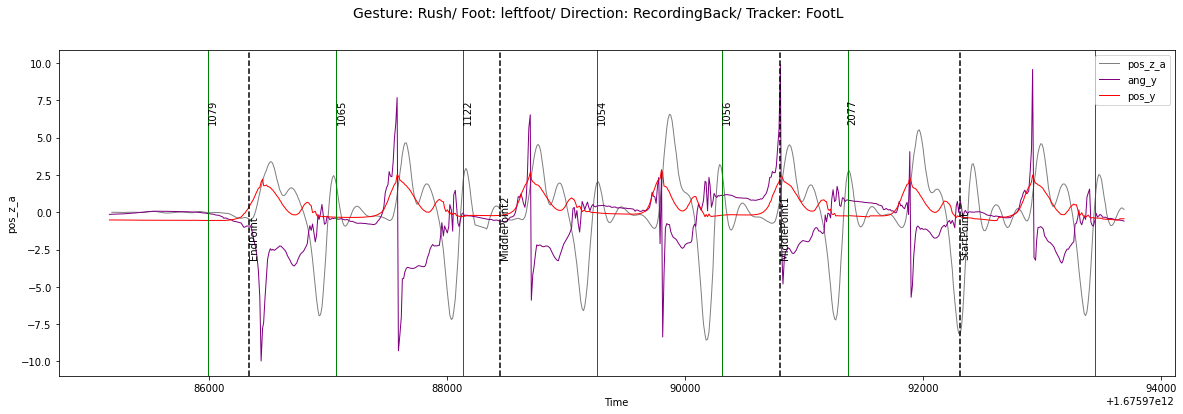

In [ ]:
plot_strides(temp_tracker_data, gesture, foot, direction, tracker_name, all_strides_df, gesture_strides, gesture_data)

In [ ]:
new_df.to_csv('all_strides_v2.csv', index=False)

In [ ]:
df = pd.read_csv('all_strides_v2.csv')
df.head()

,User,Gesture,Foot,Tracker,Direction,Start,End,Duration,Stride Count,Label,...,ang_x,ang_z_v,ang_y_v,ang_x_v,ang_z_a,ang_y_a,ang_x_a,euclidean_distance_diff,euclidean_distance_a_diff,quaternion_diff
0,User01,TapWithFootRotatedInwards,rightfoot,FootR,RecordingForth,1676319944889,1676319946023,1134,0,normal,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.341214,3.586184,2.366760
1,User01,TapWithFootRotatedInwards,rightfoot,FootR,RecordingForth,1676319946023,1676319947077,1054,1,normal,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.311326,3.226507,9.702334
2,User01,TapWithFootRotatedInwards,rightfoot,FootR,RecordingForth,1676319947077,1676319948628,1551,2,gesture,...,3.874371,8.740805,7.282766,5.616982,11.794700,8.102018,4.941548,1.241600,5.481564,2.529075
3,User01,TapWithFootRotatedInwards,rightfoot,FootR,RecordingForth,1676319948628,1676319949716,1088,3,normal,...,0.885995,3.808816,4.909896,2.711891,3.147307,4.661384,3.933754,0.772586,3.919745,3.927479
4,User01,TapWithFootRotatedInwards,rightfoot,FootR,RecordingForth,1676319949716,1676319950899,1183,4,normal,...,1.612407,6.237361,7.122934,2.332168,8.212587,6.616396,2.237610,1.250544,4.478796,4.536673


[2 4]
key_attrs: ['pos_z', 'pos_y', 'pos_x', 'pos_z_v', 'pos_y_v', 'pos_z_a', 'pos_y_a', 'ang_x', 'ang_x_a']


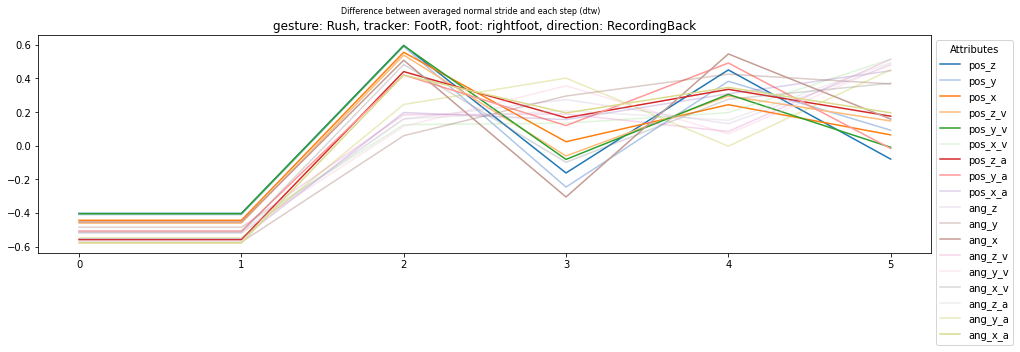

In [ ]:
fig, ax = plt.subplots(figsize=(16, 4))
ax.set_title('gesture: {}, tracker: {}, foot: {}, direction: {}'.format(gesture, tracker_name, foot, direction), fontsize=12)
fig.suptitle('Difference between averaged normal stride and each step (dtw)', fontsize=8)
foot='rightfoot'
tracker_name='FootR'

key_attrs = []
dtw_distances = {}
gesture_stride = df[(df['Gesture'] == gesture) & (df['Tracker'] == tracker_name) & (df['Foot'] == foot) & (df['Direction'] == direction) & (df['Label'] == 'gesture') & (df['User'] == user_id)]
all_strides = df[(df['Gesture'] == gesture) & (df['Tracker'] == tracker_name) & (df['Foot'] == foot) & (df['Direction'] == direction) & (df['User'] == user_id)]
print(gesture_stride['Stride Count'].values)
for index, attr in enumerate(all_attributes):
    dtw_distances[attr] = all_strides[attr].values
    dtw_distances[attr] = (dtw_distances[attr] - np.mean(dtw_distances[attr])) / (np.max(dtw_distances[attr]) - np.min(dtw_distances[attr]))

    # get the index of the two highest values
    maximums = np.argpartition(dtw_distances[attr], -2)[-2:]
    maximums = maximums[np.argsort(maximums)]

    if maximums[0] == gesture_stride['Stride Count'].values[0] and maximums[1] == gesture_stride['Stride Count'].values[1]:
        ax.plot(dtw_distances[attr], label=attr, color=plt.cm.tab20(all_attributes.index(attr)))
        ax.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Attributes')
        key_attrs.append(attr)
    else:
        ax.plot(dtw_distances[attr], label=attr, color=plt.cm.tab20(all_attributes.index(attr)), alpha=0.3)

print('key_attrs: {}'.format(key_attrs))

# ax.plot(dtw_distances['ang_y'], label='pos_y', color=plt.cm.tab20(all_attributes.index('pos_y')))
# sns.lineplot(data=dtw_distances, y='pos_z_a', x=range(len(dtw_distances['pos_z_a'])), label='pos_z_a', color=plt.cm.tab20(all_attributes.index('pos_z_a')))
# sns.lineplot(data=stumpy_distances, y='ang_y', x=range(len(stumpy_distances['ang_y'])), label='ang_y_stumpy', color='blue')

# ax.legend(bbox_to_anchor=(1.05, 1), loc='upper right', borderaxespad=0.)
plt.show()

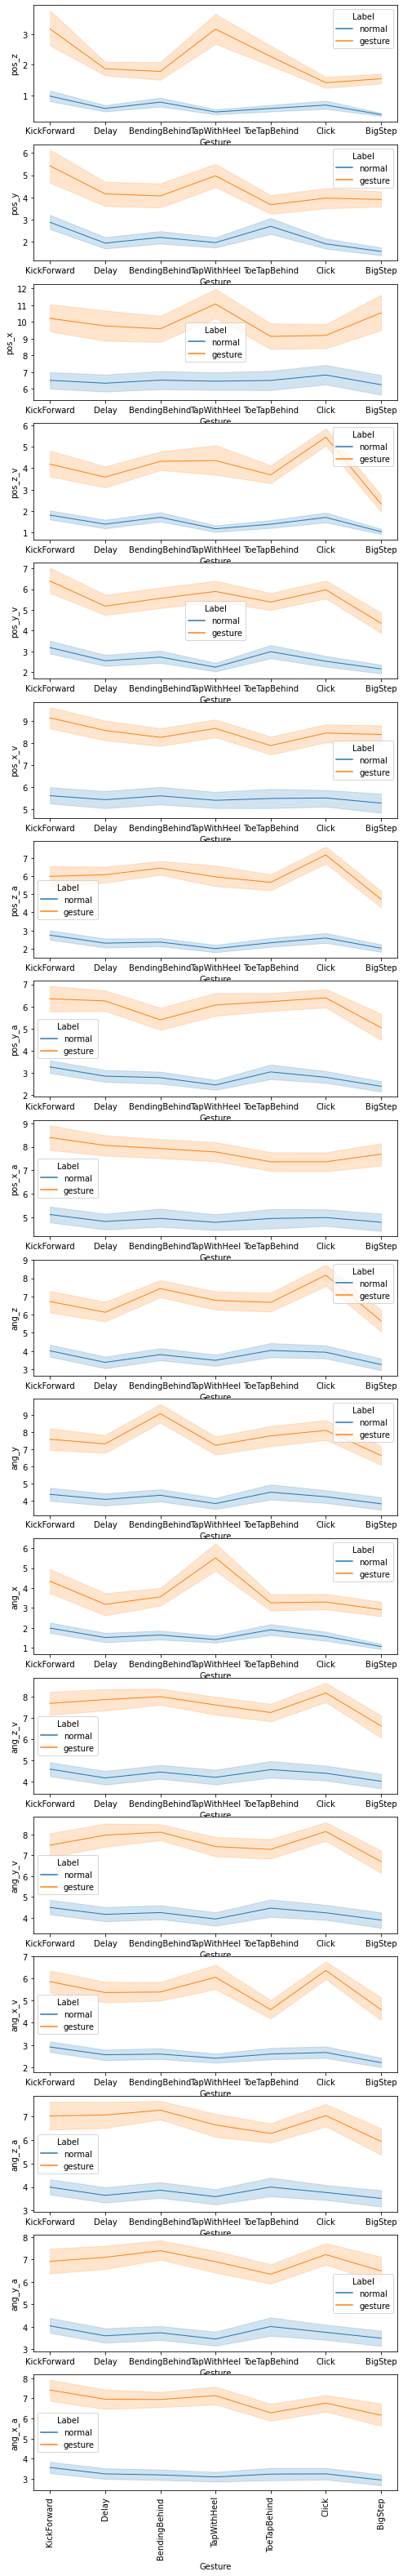

In [ ]:
df['Annotation'] = df['Annotation'].apply(lambda x: x.split('_')[0])



fig, ax = plt.subplots(len(all_attributes), 1, figsize=(8, 56))

filtered_gestures = [
    "BigStep", "Delay",
    "ToeTapBehind", "TapWithHeel",
    "Click", "LiftinFront", "BendingBehind",
    "KickForward", "NormalWalking"
]

df_filtered = df[df['Gesture'].isin(filtered_gestures)]

for index, attr in enumerate(all_attributes):
    sns.lineplot(data=df_filtered,
                 x='Gesture',
                 y=attr,
                 hue='Label',
                 linewidth=1,
                 ax=ax[index])

# sns.lineplot(x=df_filtered['Gesture'],
#              y=df_filtered['pos_y'],
#              hue=df_filtered['Label'],
#              linewidth=1)

plt.xticks(rotation=90)
plt.show()

In [ ]:
df['Annotation'].unique()

array(['before', 'gesture', 'between', 'after'], dtype=object)

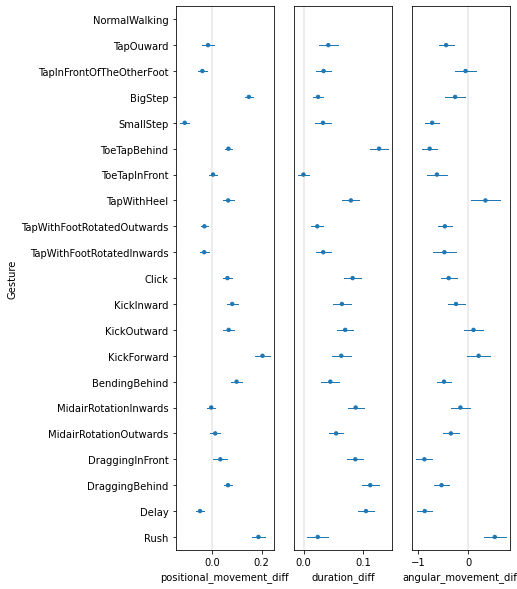

In [ ]:
# g = sns.PairGrid(df, y_vars=["Gesture"], x_vars=["Duration"], hue='Label', height=8, aspect=.5)

# g.map(sns.pointplot, color=".3", ci='sd', join=False, scale=0.5, errwidth=1, capsize=0.2)

gesture_list = [
        "NormalWalking",
        "TapOuward",
        "TapInFrontOfTheOtherFoot",
        # "TapInward",
        "BigStep",
        "SmallStep",
        "ToeTapBehind",
        "ToeTapInFront",
        "TapWithHeel",
        "TapWithFootRotatedOutwards",
        "TapWithFootRotatedInwards",
        "Click",
        "KickInward",
        "KickOutward",
        "KickForward",
        # "LiftInFront",
        "BendingBehind",
        "MidairRotationInwards",
        "MidairRotationOutwards",
        "DraggingInFront",
        "DraggingBehind",
        "Delay",
        "Rush"
    ]

plots = 3
fig, ax = plt.subplots(1, plots, figsize= (plots*2, 10))
# set image background to white
fig.patch.set_facecolor('white')

# plot the gesture in the order of the gesture list
df['Gesture'] = pd.Categorical(df['Gesture'], categories=gesture_list, ordered=True)
df['positional_movement_diff'] = df['euclidean_distance_diff'] - df['euclidean_distance_diff'].loc[df['Label'] == 'normal'].mean()
df['angular_movement_diff'] = df['quaternion_diff'] - df['quaternion_diff'].loc[df['Label'] == 'normal'].mean()
df['duration_diff'] = (df['Duration'] - df['Duration'].loc[df['Label'] == 'normal'].mean())/1000
# duration diff from ms to s

df_temp = df[(df['Annotation'] == 'before') | (df['Annotation'] == 'gesture')]

# remove the space between plots
fig.subplots_adjust(wspace=0.2)

# plot the vertical line from 0
for i in range(plots):
    ax[i].axvline(x=0, color='black', linewidth=0.2, alpha=0.7)
    # xtick every value of the x axis


# sns.pointplot(x="euclidean_distance_diff_mean", y="Gesture", hue='Label', data=df, join=False, scale=0.5, errwidth=1, errorbar=('se'), ax=ax[0])
sns.pointplot(x="positional_movement_diff", y="Gesture", data=df_temp, join=False, scale=0.5, errwidth=1, errorbar=('se'), ax=ax[0])
sns.pointplot(x="duration_diff", y="Gesture", data=df_temp, join=False, scale=0.5, errwidth=1, errorbar=('se'), ax=ax[1])
# ax[1].set_xticks(np.arange(-0.1, 0.2, 0.1))
sns.pointplot(x="angular_movement_diff", y="Gesture", data=df_temp, join=False, scale=0.5, errwidth=1, errorbar=('se'), ax=ax[2])

for i in range(1, plots):
    ax[i].set_yticks([])
    ax[i].set_ylabel('')
# ax.yaxis.grid(False)
plt.show()

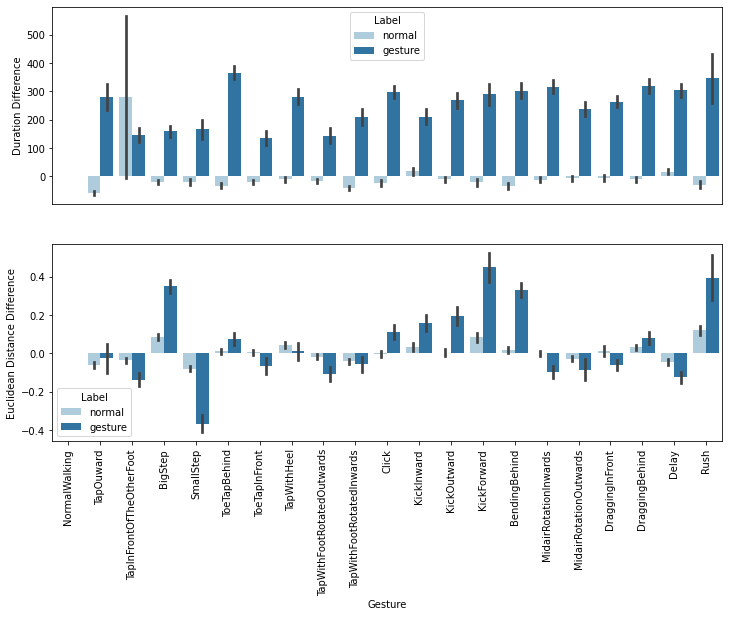

In [ ]:
# plot the duration differece between gesture and normal stride for each gesture
df['Duration Difference'] = df['Duration'] - df['Duration'].loc[df['Label'] == 'normal'].mean()
df['Euclidean Distance Difference'] = df['euclidean_distance_diff'] - df['euclidean_distance_diff'].loc[df['Label'] == 'normal'].mean()

fig, ax = plt.subplots(2, 1, figsize=(12, 8))
sns.barplot(x=df['Gesture'], y=df['Duration Difference'], hue=df['Label'], linewidth=1, errorbar=('se'), palette='Paired', ax=ax[0])
sns.barplot(x=df['Gesture'], y=df['Euclidean Distance Difference'], hue=df['Label'], linewidth=1, errorbar=('se'), palette='Paired', ax=ax[1])


plt.xticks(rotation=90)
# ax1 no x label and ticks
ax[0].set_xlabel('')
ax[0].set_xticks([])

plt.show()

Gesture Data: (5545, 13)
Gesture Data: (5725, 13)
Gesture Data: (5287, 13)
Gesture Data: (4981, 13)
Gesture Data: (4861, 13)
Gesture Data: (5269, 13)


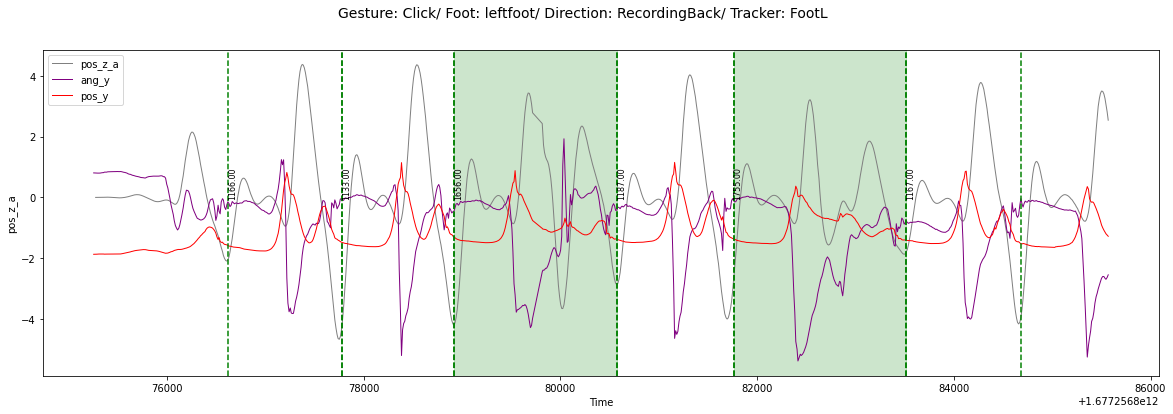

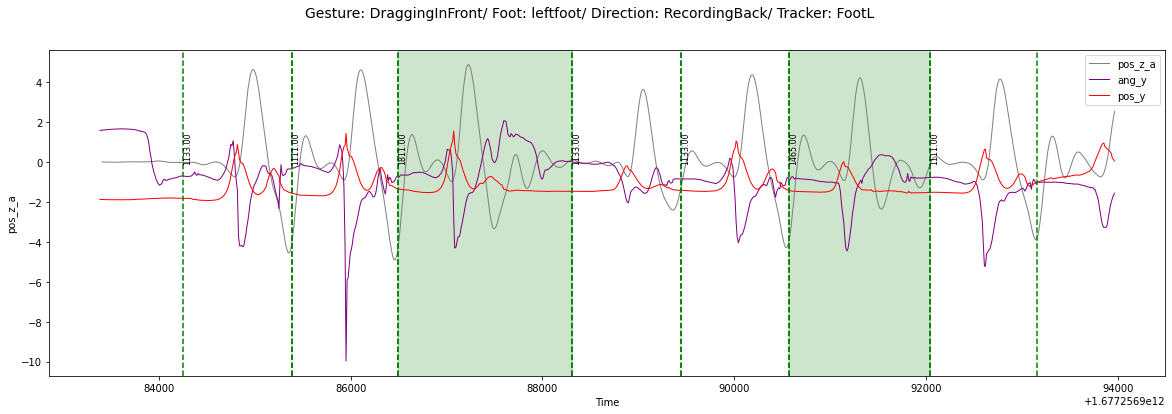

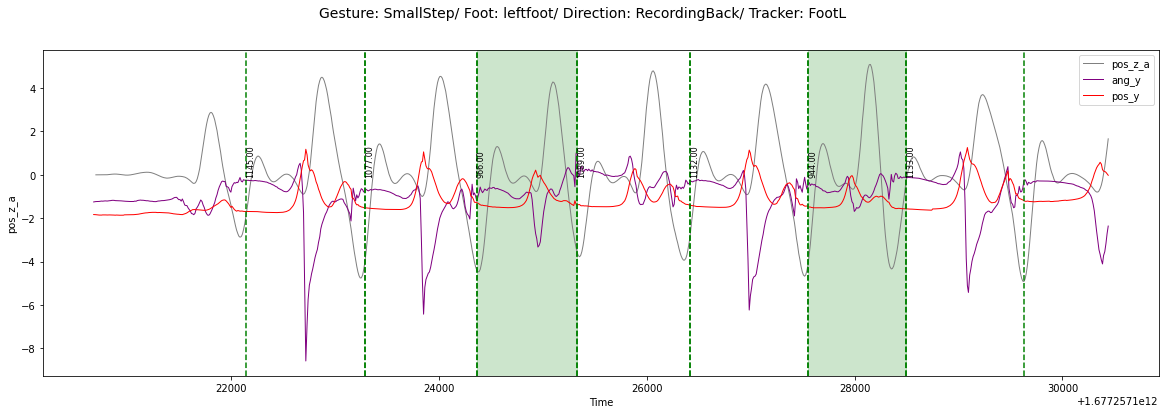

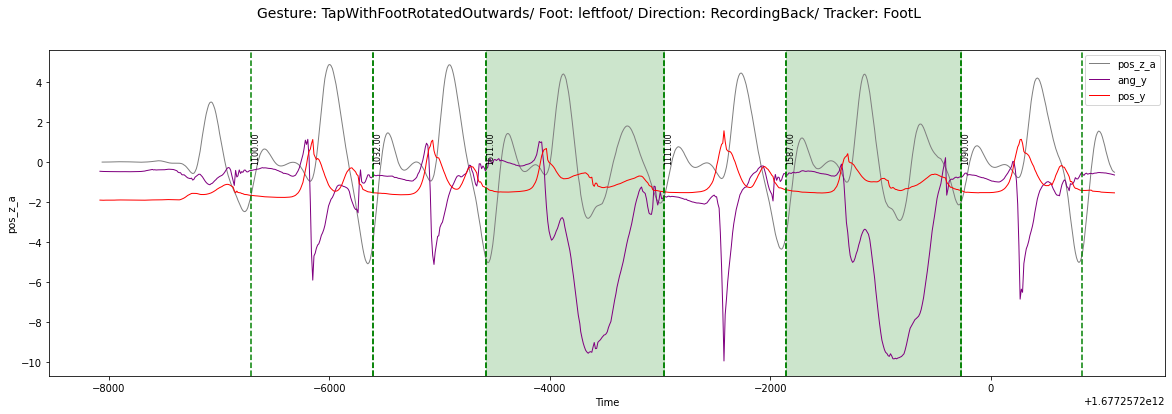

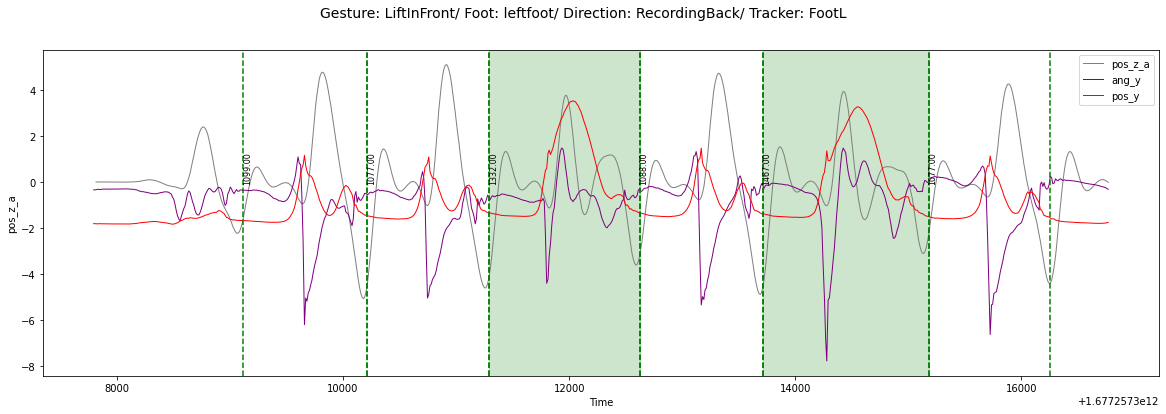

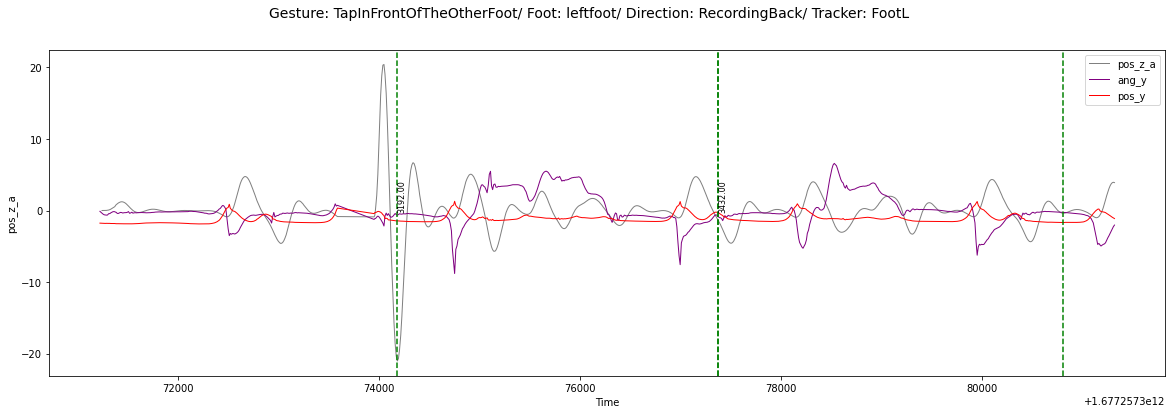

In [ ]:
gesture = 'KickForward'
foot = 'leftfoot'
direction = 'RecordingBack'
tracker_name = 'FootL'
user_id = 'User22'

all_data, all_gesture_name = fetch_data(user_id)

for gesture in all_gesture_name[1:7]:
    gesture_data = get_gesture_data(all_data, gesture, foot, direction)
    print('Gesture Data: {}'.format(gesture_data.shape))
    tracker_data, gesture_data = get_tracker_data(all_data, gesture, foot, direction, tracker_name, 4)

    strides_data = df[(df['Gesture'] == gesture) & (df['Foot'] == foot) & (df['Direction'] == direction) & (df['Tracker'] == tracker_name) & (df['User'] == user_id)]

    # 3 * 2
    fig, ax = plt.subplots(figsize=(20, 6))
    fig.suptitle('Gesture: ' + gesture + '/ Foot: ' + foot + '/ Direction: ' + direction + '/ Tracker: ' + tracker_name, fontsize=14)

    sns.lineplot(x=tracker_data['Time'], y=tracker_data['pos_z_a']
                * 1000, linewidth=1, color='grey', label='pos_z_a')
    sns.lineplot(x=tracker_data['Time'], y=tracker_data['ang_y']
                * 10, linewidth=1, color='purple', label='ang_y')
    sns.lineplot(x=tracker_data['Time'], y=tracker_data['pos_y']
                * 10, linewidth=1, color='red', label='pos_y')



    for index, stride in strides_data.iterrows():
        ax.axvline(x=stride['Start'], color='green', linestyle='--')
        ax.axvline(x=stride['End'], color='green', linestyle='--')

        if stride['Label'] == 'gesture':
            ax.axvspan(stride['Start'], stride['End'], color='green', alpha=0.2)

        # plot duration
        ax.text(stride['Start'], 0, '{:.2f}'.format(stride['Duration']), rotation=90, fontsize=8)

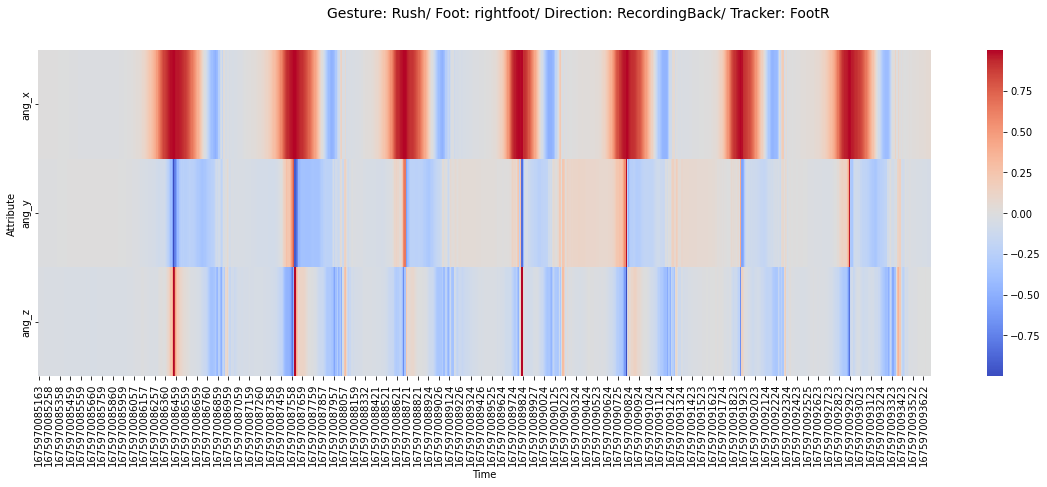

In [ ]:
"""
Visualization of the angular movement compare to the position movement

You can also use a heatmap to visualize the angular movement over time. In this type of visualization, time is represented on the x-axis, and the different angular attributes are represented on the y-axis. The values for each angular attribute can be color-coded to show the intensity of the angular movement at each point in time.
"""

fig, ax = plt.subplots(figsize=(20, 6))
fig.suptitle('Gesture: ' + gesture + '/ Foot: ' + foot + '/ Direction: ' + direction + '/ Tracker: ' + tracker_name, fontsize=14)

heatmap_data = tracker_data[['Time', 'ang_x', 'ang_y', 'ang_z']]
heatmap_data = heatmap_data.set_index('Time')
heatmap_data = heatmap_data.T
heatmap_data = heatmap_data.reset_index()
heatmap_data = heatmap_data.rename(columns={'index': 'Attribute'})
heatmap_data = heatmap_data.melt(id_vars=['Attribute'], var_name='Time', value_name='Value')

sns.heatmap(heatmap_data.pivot('Attribute', 'Time', 'Value'), cmap='coolwarm', ax=ax)
plt.show()